<a href="https://colab.research.google.com/github/bonareri/Machine_Learning_1/blob/main/Email_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Email Spam Detection**

## **Loading Libraries**

In [1]:
# Impoting general libraries
import warnings
import itertools
import random

# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PolynomialFeatures

# Class Imbalance
from imblearn.over_sampling import SMOTE

# CV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Machine Learning Model Evaluation Methods
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix


warnings.filterwarnings(action="ignore")
%matplotlib inline

## Loading and Exploring the Dataset

In [15]:
spam_detection = pd.read_csv("/content/spam_ham_dataset.csv")
spam_detection.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [16]:
spam_detection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [17]:
# Drop the unnecessary column
spam_detection = spam_detection.drop(columns=['Unnamed: 0'])
spam_detection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


## Text Preprocessing

- Lowercasing: Convert all text to lowercase for consistency.
- Remove Punctuation: Eliminate punctuations to focus on words.
- Tokenization: Break the text into individual words.
- Remove Stop Words: Exclude common words like "the", "and", "is", which don't carry much information.
- Stemming/Lemmatization: Reduce words to their root forms (e.g., "running" → "run").
- Remove Special Characters: Exclude non-alphanumeric characters.
Handling URLs/Emails: Replace them with placeholders like <URL> or <EMAIL>.

In [18]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Ensure the required NLTK data files are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the enhanced cleaning function
def clean_email(text):
    # Check if the input is a string
    if not isinstance(text, str):
        return ''

    # Convert to lowercase
    text = text.lower()

    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text)

    # Replace email addresses with a placeholder
    text = re.sub(r'\S+@\S+', '<EMAIL>', text)

    # Remove newline characters, carriage returns, and tabs
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    words = text.split()

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply the cleaning function to the 'text' column
spam_detection['cleaned_text'] = spam_detection['text'].apply(clean_email)

# Display a sample of the original and cleaned text
print(spam_detection[['text', 'cleaned_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  Subject: enron methanol ; meter # : 988291\r\n...   
1  Subject: hpl nom for january 9 , 2001\r\n( see...   
2  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3  Subject: photoshop , windows , office . cheap ...   
4  Subject: re : indian springs\r\nthis deal is t...   

                                        cleaned_text  
0  subject enron methanol meter follow note gave ...  
1  subject hpl nom january see attached file hpln...  
2  subject neon retreat ho ho ho around wonderful...  
3  subject photoshop window office cheap main tre...  
4  subject indian spring deal book teco pvr reven...  


## Split the Dataset

In [19]:
from sklearn.model_selection import train_test_split

# Features and labels
X = spam_detection['cleaned_text']  # Use the cleaned text
y = spam_detection['label_num']    # Use the numeric labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data: {len(X_train)}, Testing data: {len(X_test)}")

Training data: 4136, Testing data: 1035


##  Vectorization

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the training data; transform the testing data
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

## Train the Model

In [21]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the model
model = MultinomialNB()

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

## Evaluate the Model

Accuracy: 0.9536231884057971

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       742
           1       0.91      0.93      0.92       293

    accuracy                           0.95      1035
   macro avg       0.94      0.95      0.94      1035
weighted avg       0.95      0.95      0.95      1035



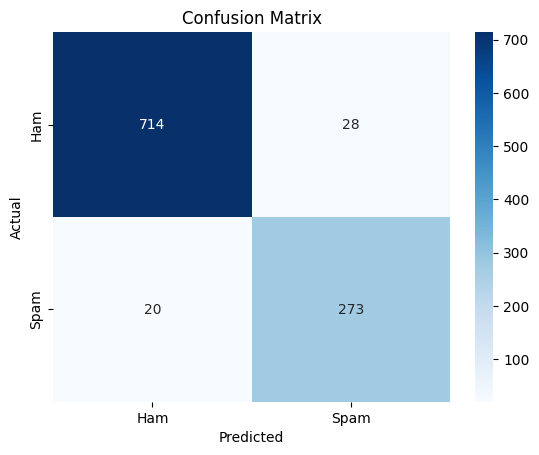

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()